In [1]:
# import packages
from cl_sster import cl_sster
import numpy as np
import os
import scipy.io as sio
from postprocessing_utils import calc_isc, calc_isc_train
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from postprocessing_utils import plot_dendrogram
import torch
import mne

In [2]:
# parameters
fs = 128
epochs_pretrain = 50
data_type = 'speech'

In [3]:
# Load speech data
datadir = r'E:\Data\speechData_Broderick_CurrentBiology\doi_10.5061_dryad.070jc__v3\Natural Speech\EEG\ICA'
print(datadir)
n_points = sio.loadmat(os.path.join(datadir, 'n_points.mat'))['n_points'][0]
n_vids = len(n_points)
data = np.load(os.path.join(datadir, 'data_all.npy'))
n_subs = data.shape[0]
print(data.shape)

# Normalization without outliers
print('Normalizing')
for sub in range(n_subs):
    thr = 30 * np.median(abs(data[sub]))
    data[sub] = (data[sub] - np.mean(data[sub][data[sub] < thr])) / np.std(data[sub][data[sub] < thr])

E:\Data\speechData_Broderick_CurrentBiology\doi_10.5061_dryad.070jc__v3\Natural Speech\EEG\ICA
(19, 449221, 128)
Normalizing


In [4]:
# Train with all data
isFirstTrain=False # If False, the model will load the trained parameters to get hidden
cl_model_allData = cl_sster(n_folds=1, epochs_pretrain=epochs_pretrain, data_type='speech') # If n_folds == 1, it will use all data to train the model
cl_model_allData.load_data(data, n_points) # fs: sampling rate
if isFirstTrain:
    cl_model_allData.train_cl_sster() # Train the model
out, n_points_cum = cl_model_allData.get_hidden(fold=0) # The function will load the trained model and get hidden representations

is cuda available: True
The results will be saved to: results/speech/timeLen30_wd0.100000_epochs50_tfLen30_avgPool15_timeStep15.000_all
checkpoint: results/speech/timeLen30_wd0.100000_epochs50_tfLen30_avgPool15_timeStep15.000_all\0\checkpoint_0049.pth.tar


In [5]:
# Calculate ISC for the model trained with all data
out_all_corr_mean = calc_isc_train(out.transpose(2,1,0), n_points_cum)

In [6]:
# Visualize the hierarchical clustering results
nonzero_dims = cl_model_allData.check_nonzero_dims()
out_corr_dims_mean = cl_model_allData.calc_out_corr_dims() # Only used nonzero dims here
affinity_mat = 1 - np.abs(out_corr_dims_mean)
cluster_model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, metric='precomputed', linkage='average')
cluster_model = cluster_model.fit(affinity_mat)
sio.savemat(os.path.join(cl_model_allData.save_dir, 'nonzero_dims.mat'), {'nonzero_dims': nonzero_dims})

length of nonzero dims 256


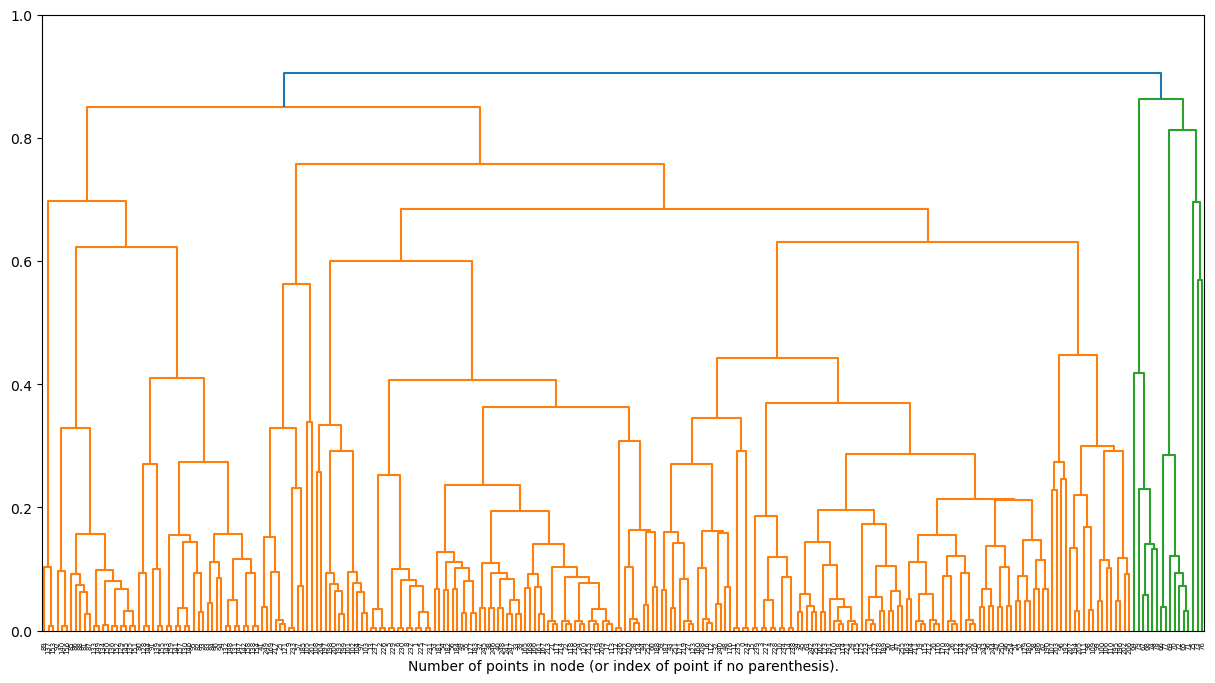

In [11]:
plt.figure(figsize=(15,8))
R = plot_dendrogram(cluster_model, truncate_mode="level", p=15, color_threshold=0.9)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylim([0,1])
plt.savefig(os.path.join(cl_model_allData.save_dir, 'hier_cluster.jpg'))
plt.show()

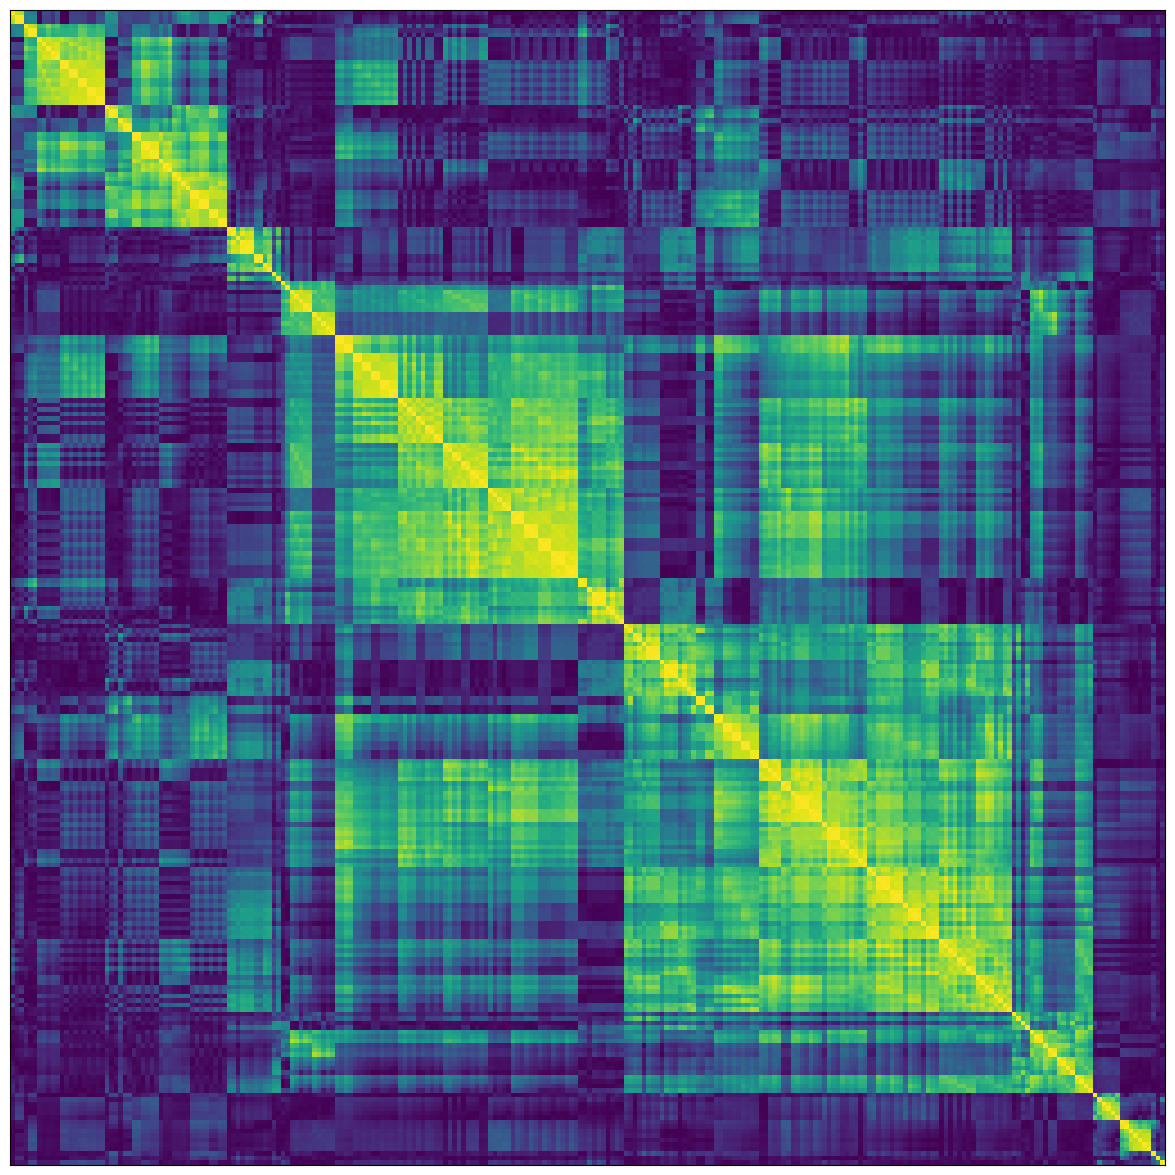

In [12]:
inds_reorder = np.zeros(len(R['ivl'])).astype(int)
for i in range(len(R['ivl'])):
    inds_reorder[i] = int(R['ivl'][i])
# print(inds_reorder)

plt.figure(figsize=(15,15))
plt.imshow(1-affinity_mat[inds_reorder, :][:, inds_reorder])
plt.xticks([])
plt.yticks([])
plt.savefig(os.path.join(cl_model_allData.save_dir, 'affinity_mat.jpg'))
plt.show()

In [13]:
# Get the clusters 
cluster_model = AgglomerativeClustering(distance_threshold=0.9, n_clusters=None, metric='precomputed', linkage='average')
cluster_model = cluster_model.fit(affinity_mat)
c_labels = cluster_model.labels_
n_clusters = len(np.unique(c_labels))

In [14]:
# Get the diemensions with best ISC in each cluster (trained with all data)
isc_mean = np.mean(out_all_corr_mean, axis=1)
isc_mean_sel = isc_mean[nonzero_dims]
inds_order = np.arange(len(nonzero_dims))
inds_cluster_max = np.zeros(n_clusters).astype(int)
for i in range(n_clusters):
    tmp = np.argmax(isc_mean_sel[c_labels==i])
    inds_cluster_max[i] = nonzero_dims[int(inds_order[c_labels==i][tmp])]
print(inds_cluster_max)
print(isc_mean[inds_cluster_max])
sio.savemat(os.path.join(cl_model_allData.save_dir, 'inds_cluster_max.mat'), {'inds_cluster_max':inds_cluster_max})

[ 69 116]
[0.0187226  0.05554685]


In [15]:
# See the filter indices in each cluster
ts_lists = {}
for j in range(n_clusters):
    ts_lists[j] = []

tree_order = []
for i in range(len(R['ivl'])):
    ind_now_new = int(R['ivl'][i])
    ind_now = nonzero_dims[ind_now_new]
    # print(ind_now, c_labels[ind_now_new], ind_now//16+1, np.mod(ind_now+1, 16))
    ts_lists[c_labels[ind_now_new]].append([ind_now//16+1, np.mod(ind_now+1,16)])
    if c_labels[ind_now_new] not in tree_order:
        tree_order.append(c_labels[ind_now_new])
    
for j in range(n_clusters):
    tmp = np.array(ts_lists[tree_order[j]])
    print(j, 'temporal:', np.unique(tmp[:,0]))
    print('  spatial:', np.unique(tmp[:,1]))

0 temporal: [ 1  2  3  4  6  7  8  9 10 11 12 13 14 15 16]
  spatial: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
1 temporal: [5]
  spatial: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


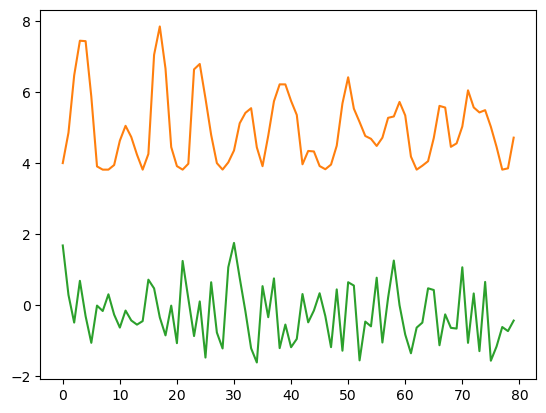

In [16]:
# Plot examples of the representative dimensions
tmp = out[0,inds_cluster_max[tree_order],:80].transpose()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(n_clusters):
    plt.plot(tmp[:,i]+(n_clusters-1-i)*5, color=colors[i+1])
plt.show()

In [17]:
# Train the cross-validation model
cl_model = cl_sster(n_folds=n_subs, epochs_pretrain=epochs_pretrain, data_type='speech')
cl_model.load_data(data, n_points) # fs: sampling rate
if isFirstTrain:
    cl_model.train_cl_sster()

is cuda available: True
The results will be saved to: results/speech/timeLen30_wd0.100000_epochs50_tfLen30_avgPool15_timeStep15.000_cv


In [18]:
# Get the corresponding dimensions in each training fold
correspondDims_fold, corr_mean_fold = cl_model.get_correspond_dims(n_folds=n_subs, out=out, calc_dims=inds_cluster_max)

checkpoint: results/speech/timeLen30_wd0.100000_epochs50_tfLen30_avgPool15_timeStep15.000_cv\0\checkpoint_0049.pth.tar
checkpoint: results/speech/timeLen30_wd0.100000_epochs50_tfLen30_avgPool15_timeStep15.000_cv\1\checkpoint_0049.pth.tar
checkpoint: results/speech/timeLen30_wd0.100000_epochs50_tfLen30_avgPool15_timeStep15.000_cv\2\checkpoint_0049.pth.tar
checkpoint: results/speech/timeLen30_wd0.100000_epochs50_tfLen30_avgPool15_timeStep15.000_cv\3\checkpoint_0049.pth.tar
checkpoint: results/speech/timeLen30_wd0.100000_epochs50_tfLen30_avgPool15_timeStep15.000_cv\4\checkpoint_0049.pth.tar
checkpoint: results/speech/timeLen30_wd0.100000_epochs50_tfLen30_avgPool15_timeStep15.000_cv\5\checkpoint_0049.pth.tar
checkpoint: results/speech/timeLen30_wd0.100000_epochs50_tfLen30_avgPool15_timeStep15.000_cv\6\checkpoint_0049.pth.tar
checkpoint: results/speech/timeLen30_wd0.100000_epochs50_tfLen30_avgPool15_timeStep15.000_cv\7\checkpoint_0049.pth.tar
checkpoint: results/speech/timeLen30_wd0.100000_

In [19]:
# Calculate training and validation ISC in each fold
n_folds = n_subs
n_per = int(n_subs // n_folds)
isc_train_folds = np.zeros((n_folds, n_subs, n_clusters)) - 2.
isc_val_folds = np.zeros((n_folds, n_clusters))

for val_fold in range(n_folds):
    if val_fold < n_folds-1:
        val_sub = np.arange(val_fold*n_per, (val_fold+1)*n_per)
    else:
        val_sub = np.arange(val_fold*n_per, n_subs)
    train_sub = list(set(np.arange(n_subs)) - set(val_sub))
    sub_order = np.concatenate((train_sub, val_sub))
    
    # Note that out will be overwritten here (for out of the cl_model_all)
    out, n_points_cum = cl_model.get_hidden(val_fold)
    out = out[sub_order,:,:]
    out_train_corr_mean, out_val_corr_mean = calc_isc(out.transpose(2,1,0), n_points_cum, len(train_sub))
    
    isc_train_folds[val_fold, train_sub, :] = out_train_corr_mean[correspondDims_fold[val_fold],:].transpose()
    isc_val_folds[val_fold, :] = out_val_corr_mean[correspondDims_fold[val_fold]].squeeze()
    
isc_train_mean = np.zeros((n_subs, n_clusters))
for sub in range(n_subs):
    for dim in range(n_clusters):
        isc_train_mean[sub,dim] = np.mean(isc_train_folds[:,sub,dim][isc_train_folds[:,sub,dim]!=-2], axis=0)
isc_train_std = np.std(isc_train_mean, axis=0)
isc_train_mean = np.mean(isc_train_mean, axis=0)
print('isc train mean, std: ')
print(isc_train_mean, isc_train_std)

isc_val_mean = np.mean(isc_val_folds, axis=0)
isc_val_std = np.std(isc_val_folds, axis=0)
print('isc val mean, std: ')
print(isc_val_mean, isc_val_std)
sio.savemat(os.path.join(cl_model.save_dir, 'isc.mat'), {'isc_train': isc_train_mean, 'isc_val': isc_val_folds})

checkpoint: results/speech/timeLen30_wd0.100000_epochs50_tfLen30_avgPool15_timeStep15.000_cv\0\checkpoint_0049.pth.tar
checkpoint: results/speech/timeLen30_wd0.100000_epochs50_tfLen30_avgPool15_timeStep15.000_cv\1\checkpoint_0049.pth.tar
checkpoint: results/speech/timeLen30_wd0.100000_epochs50_tfLen30_avgPool15_timeStep15.000_cv\2\checkpoint_0049.pth.tar
checkpoint: results/speech/timeLen30_wd0.100000_epochs50_tfLen30_avgPool15_timeStep15.000_cv\3\checkpoint_0049.pth.tar
checkpoint: results/speech/timeLen30_wd0.100000_epochs50_tfLen30_avgPool15_timeStep15.000_cv\4\checkpoint_0049.pth.tar
checkpoint: results/speech/timeLen30_wd0.100000_epochs50_tfLen30_avgPool15_timeStep15.000_cv\5\checkpoint_0049.pth.tar
checkpoint: results/speech/timeLen30_wd0.100000_epochs50_tfLen30_avgPool15_timeStep15.000_cv\6\checkpoint_0049.pth.tar
checkpoint: results/speech/timeLen30_wd0.100000_epochs50_tfLen30_avgPool15_timeStep15.000_cv\7\checkpoint_0049.pth.tar
checkpoint: results/speech/timeLen30_wd0.100000_

In [20]:
inds_cluster_reorder = np.argsort(isc_val_mean)[::-1]
print(inds_cluster_reorder)

print('reordered validation mean, std:')
print(isc_val_mean[inds_cluster_reorder], isc_val_std[inds_cluster_reorder])

[1 0]
reordered validation mean, std:
[0.04982018 0.01437114] [0.01351177 0.00969918]


odict_keys(['spatialConv.weight', 'spatialConv.bias', 'timeConv.weight', 'timeConv.bias'])
(16, 128) (16, 30)
Temporal filter: 0


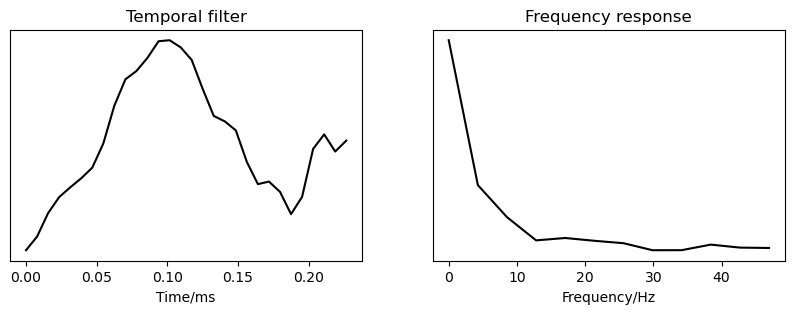

Temporal filter: 1


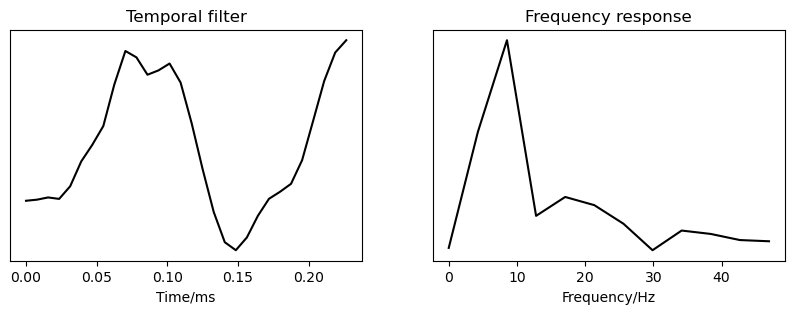

In [21]:
# Visualize the filters
state_dict = torch.load(os.path.join(cl_model_allData.save_dir, '0', 'checkpoint_%04d.pth.tar' % (epochs_pretrain-1)))['state_dict']
print(state_dict.keys())

spatialWeight = torch.squeeze(state_dict['spatialConv.weight']).cpu().numpy()
timeWeight = torch.squeeze(state_dict['timeConv.weight']).cpu().numpy()
print(spatialWeight.shape, timeWeight.shape)

n_timeFilters, n_spatialFilters = timeWeight.shape[0], spatialWeight.shape[0]
time_inds = (inds_cluster_max[inds_cluster_reorder] // 16).astype(int)
spatial_inds = np.mod(inds_cluster_max[inds_cluster_reorder], 16)
if isinstance(time_inds, int):
    time_inds, spatial_inds = [time_inds], [spatial_inds]

timeFilterLen = timeWeight.shape[1]
f = fs * np.arange(timeFilterLen) / timeFilterLen
for i in range(len(time_inds)):
    print('Temporal filter: %d' % i)
    plt.figure(figsize=(10,3))
    sp = np.abs(np.fft.fft(timeWeight[time_inds[i], ::-1]))
    plt.subplot(121)
    plt.plot(np.arange(0,1/128*30,1/128), timeWeight[time_inds[i]], 'k')
    plt.yticks([])
    plt.xlabel('Time/ms')
    plt.title('Temporal filter')
    plt.subplot(122)
    plt.plot(f[f<=50], sp[f<=50], 'k')
    plt.yticks([])
    plt.xlabel('Frequency/Hz')
    plt.title('Frequency response')
    plt.show()

['standard_1005', 'standard_1020', 'standard_alphabetic', 'standard_postfixed', 'standard_prefixed', 'standard_primed', 'biosemi16', 'biosemi32', 'biosemi64', 'biosemi128', 'biosemi160', 'biosemi256', 'easycap-M1', 'easycap-M10', 'easycap-M43', 'EGI_256', 'GSN-HydroCel-32', 'GSN-HydroCel-64_1.0', 'GSN-HydroCel-65_1.0', 'GSN-HydroCel-128', 'GSN-HydroCel-129', 'GSN-HydroCel-256', 'GSN-HydroCel-257', 'mgh60', 'mgh70', 'artinis-octamon', 'artinis-brite23', 'brainproducts-RNP-BA-128']


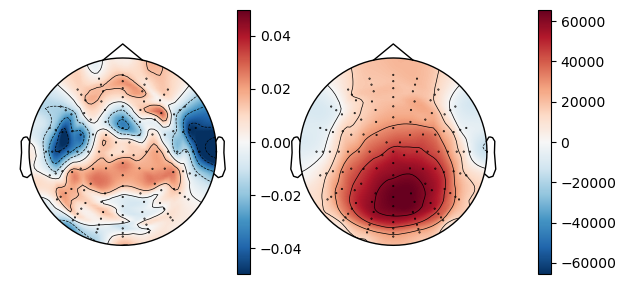

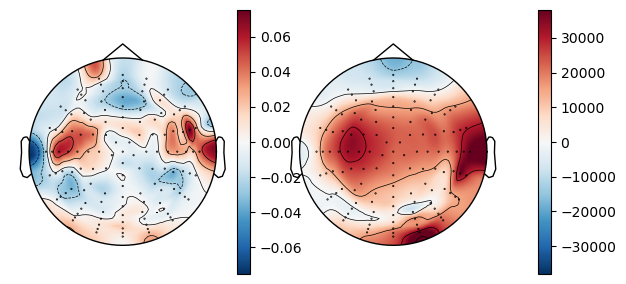

In [22]:
# Calculate data covariance for spatial activation
data_cov = np.zeros((data.shape[-1], data.shape[-1]))
for i in range(n_subs):
    data_cov = data_cov + np.dot(data[i,:,:].transpose(), data[i,:,:])
data_cov = data_cov / n_subs

# Plot topo of spatial activation
print(mne.channels.get_builtin_montages())
chn_names_array = sio.loadmat(r'D:\Data\Speech\speechData_Broderick_CurrentBiology\doi_10.5061_dryad.070jc__v3\Natural Speech\EEG\prep_code\chn_names.mat')['chn_names']
chn_names = [chn_names_array[0][i][0] for i in range(len(chn_names_array[0]))]
Info = mne.create_info(ch_names=chn_names, sfreq=128, ch_types='eeg')
Info.set_montage('biosemi128')

spatialActivation = np.dot(data_cov, spatialWeight.transpose()).transpose()
for i in range(len(spatial_inds)):
    w_curr = spatialWeight[spatial_inds[i]]
    a_curr = spatialActivation[spatial_inds[i]]
    vlim_max_w, vlim_max_a = np.max(np.abs(w_curr)), np.max(np.abs(a_curr))
    
    fig,(ax1,ax2) = plt.subplots(ncols=2)
    im,cm   = mne.viz.plot_topomap(spatialWeight[spatial_inds[i],:].squeeze(), Info, axes=ax1,show=False, vlim=[-vlim_max_w,vlim_max_w])   
    # manually fiddle the position of colorbar
    ax_x_start = 0.48
    ax_x_width = 0.02
    ax_y_start = 0.25
    ax_y_height = 0.55
    cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
    clb = fig.colorbar(im, cax=cbar_ax)
    
    im,cm   = mne.viz.plot_topomap(spatialActivation[spatial_inds[i],:].squeeze(), Info, axes=ax2,show=False, vlim=[-vlim_max_a,vlim_max_a])   
    # manually fiddle the position of colorbar
    ax_x_start = 0.95
    ax_x_width = 0.02
    ax_y_start = 0.25
    ax_y_height = 0.55
    cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
    clb = fig.colorbar(im, cax=cbar_ax)
    # mne.viz.plot_topomap(spatialActivation[spatial_inds[i],:].squeeze(), pos=Info, size=4)

In [23]:
sio.savemat(os.path.join(cl_model_allData.save_dir, 'params.mat'), 
            {'timeWeight': timeWeight, 'spatialWeight': spatialWeight, 
             'spatialActivation': spatialActivation})